In [126]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import HTML
from pybounds import Simulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
from double_pendulum import DoublePendulumParameters, DoublePendulumModel, DoublePendulumDrawer

In [128]:
# Now import the dual antenna class
from double_pendulum import DualAntennaPendulumDrawer
print("Successfully imported DualAntennaPendulumDrawer!")

Successfully imported DualAntennaPendulumDrawer!


# Set model parameters

In [129]:
dt = 0.05  #  time-step [s]

In [130]:
params = DoublePendulumParameters(
    g=0.0,  # gravity
    k_1=0.0, k_2=1.0,  # torsional stiffness
    c_1=1.0, c_2=1.0,  # torsional damping
    L_1=1.0, L_2=1.0,  # length
    m_1=1.0, m_2=1.0,  # mass
    c_w_1=0.0, c_w_2=0.0,  # wind damping
    J_1=None, J_2=None,  # inertia automatically computed based on cylinder model
)
model = DoublePendulumModel(parameters=params)
model.parameters.__dict__

{'g': 0.0,
 'L_1': 1.0,
 'L_2': 1.0,
 'k_1': 0.0,
 'k_2': 1.0,
 'c_1': 1.0,
 'c_2': 1.0,
 'm_1': 1.0,
 'm_2': 1.0,
 'c_w_1': 0.0,
 'c_w_2': 0.0,
 'J_1': 0.08333333333333333,
 'J_2': 0.08333333333333333}

# Construct simulator object

In [131]:
simulator = Simulator(model.f, model.h,
                      dt=dt,
                      state_names=model.state_names,
                      input_names=model.input_names,
                      measurement_names=model.measurement_names)

# Set inputs

In [132]:
T = 5.0  # total time [s]
tsim = np.arange(start=0.0, stop=T + 1e-3, step=dt)  # time vector [s]

In [133]:
NA = np.zeros_like(tsim)

setpoint = {'x': 0.0 * np.ones_like(tsim),
            'y': 0.0 * np.ones_like(tsim),
            'theta_1': (np.pi/16) * np.sin(2*np.pi*(3/T)*tsim),
            'theta_2': 0.0 * np.ones_like(tsim),
            'x_dot': NA,
            'y_dot': NA,
            'theta_dot_1': NA,
            'theta_dot_2': NA,
            'w': NA,  # ambient wind speed [m/s]
            'zeta': NA ,
            }

# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

# Set up model predictive control

In [134]:
# Define cost function
cost = ((simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2 +
        (simulator.model.x['y'] - simulator.model.tvp['y_set']) ** 2 +
        (simulator.model.x['theta_1'] - simulator.model.tvp['theta_1_set']) ** 2
        )

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)

In [135]:
# Set input penalty: make this small for accurate state following
simulator.mpc.set_rterm(x_ddot=1e-6, y_ddot=1e-6, tau_1=1e-6, tau_2=1e12)

# Run simulation in closed-loop

In [136]:
t_sim, x_sim, u_sim, y_sim = simulator.simulate(mpc=True,  return_full_output=True)
sim_data = pd.DataFrame(y_sim)
sim_data.insert(0, 'time', t_sim)
sim_data

,time,theta_1,theta_2,theta_dot_1,theta_dot_2,x,y,x_dot,y_dot,w,zeta,x_ddot,y_ddot,tau_1,tau_2,theta_2_1
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-1.369359,0.053495,13.379680,-2.367057e-17,0.000000
1,0.05,0.025603,-0.032686,0.934706,-1.120151,-0.001712,0.000067,-0.068468,0.002675,0.0,0.0,1.805548,-0.033720,6.289344,-1.732230e-17,-0.058289
2,0.10,0.070049,-0.080990,0.853561,-0.833738,-0.002878,0.000158,0.021809,0.000989,0.0,0.0,0.551439,-0.099179,2.091478,-1.344397e-17,-0.151039
3,0.15,0.106323,-0.108158,0.625624,-0.312548,-0.001098,0.000084,0.049381,-0.003970,0.0,0.0,-0.729464,0.046360,1.134904,-1.376867e-17,-0.214481
4,0.20,0.134799,-0.114457,0.528625,0.028051,0.000459,-0.000057,0.012908,-0.001652,0.0,0.0,-0.457293,0.054959,0.472572,-1.445602e-17,-0.249256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4.80,-0.134551,-0.154306,0.531850,-1.086930,-0.000185,0.000059,0.004601,0.000249,0.0,0.0,0.264223,-0.062884,6.120416,-9.573504e-19,-0.019754
97,4.85,-0.105511,-0.206488,0.624704,-0.990269,0.000375,-0.000008,0.017812,-0.002895,0.0,0.0,-0.302297,-0.010348,6.293309,-2.730058e-18,-0.100978
98,4.90,-0.071311,-0.253194,0.738345,-0.867804,0.000888,-0.000165,0.002697,-0.003413,0.0,0.0,-0.830093,0.193037,4.533877,-2.150320e-18,-0.181883
99,4.95,-0.034176,-0.288874,0.754381,-0.574745,-0.000015,-0.000095,-0.038808,0.006239,0.0,0.0,0.583735,-0.012491,-0.883486,4.599494e-18,-0.254698


# Animate

In [137]:
plt.rcParams['animation.embed_limit'] = 100

In [138]:
drawer = DoublePendulumDrawer(
    sim_data['x'].values,
    sim_data['y'].values,
    sim_data['theta_1'].values,
    sim_data['theta_2'].values,
    L1=model.parameters.L_1,
    L2=model.parameters.L_2,
    seg1_kwargs=dict(color='blue', linewidth=4.0, markersize=7),
    seg2_kwargs=dict(color='red', linewidth=4.0, markersize=7),
    trail1=True, trail2=True, trail_base=True
)

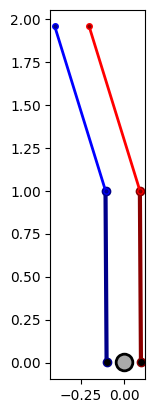

In [139]:

# 1. Prepare your data arrays
base_x = sim_data['x'].values    # Fly body x positions
base_y = sim_data['y'].values      # Fly body y positions  
theta1_left = sim_data['theta_1'].values  # Left antenna first segment angles
theta2_left = sim_data['theta_2'].values  # Left antenna second segment angles
theta1_right = sim_data['theta_1'].values # Right antenna first segment angles
theta2_right = sim_data['theta_2'].values # Right antenna second segment angles

# 2. Create the drawer
drawer = DualAntennaPendulumDrawer(
    base_x, base_y,
    theta1_left, theta2_left, theta1_right, theta2_right
)

# 3. Draw it
fig, ax = plt.subplots()
drawer.draw(ax, frame=-1)  # Draw last frame
ax.set_aspect('equal')
plt.show()

In [140]:
# Replace your drawer creation with this:
dual_drawer = DualAntennaPendulumDrawer(
    sim_data['x'].values,  
    sim_data['y'].values,  
    sim_data['theta_1'].values,  # Left: -60° bias
    sim_data['theta_2'].values,
    sim_data['theta_1'].values,  # Right: +60° bias  
    sim_data['theta_2'].values,
    
    L1_left=model.parameters.L_1,
    L2_left=model.parameters.L_2,
    L1_right=model.parameters.L_1,
    L2_right=model.parameters.L_2,
    
    # Very distinct colors
    left_seg1_kwargs=dict(color='blue', linewidth=5.0, markersize=8),
    left_seg2_kwargs=dict(color='cyan', linewidth=4.0, markersize=6),
    right_seg1_kwargs=dict(color='red', linewidth=5.0, markersize=8),
    right_seg2_kwargs=dict(color='magenta', linewidth=4.0, markersize=6),
    
    trail2_left=True,   # Only tip trails for clarity
    trail2_right=True,
    trail_base=True,
    
    body_style='dot',
    body_kwargs=dict(markersize=15, color='yellow', markerfacecolor='orange')
)

In [141]:
# Make figure
fig, ax = plt.subplots(nrows=1, ncols=1)

def update(frame):
    ax.clear()
    dual_drawer.draw(ax, frame=frame)
    ax.set_aspect('equal')
    ax.axis(drawer.get_axis_bounds())

# Make animation
animation = mpl.animation.FuncAnimation(
    fig, update,
    frames=sim_data.shape[0],
    blit=False,
    interval=int(1000 * dt))

# update(0)
plt.close(fig)

In [142]:
# Display it
HTML(animation.to_jshtml())

In [143]:
# Save it
# from matplotlib.animation import PillowWriter
# save_path = os.path.join(os.path.pardir, 'animation', 'example_model predictive_control.gif')
# animation.save(save_path, PillowWriter(fps=int(1/dt)))